In [1]:
import os
import os.path as osp
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imsave, imread
from skimage import img_as_ubyte, img_as_float
import sys
import torch

%load_ext autoreload
%autoreload 2

In [2]:
def imshow_pair(im, gdt, vmin1=None, vmax1=None, vmin2=None, vmax2=None):
    f, ax = plt.subplots(1, 2, figsize=(10,5))
    np_im = np.asarray(im)
    np_gdt = np.asarray(gdt)
    if len(np_im.shape) == 2:
        if vmin1==None:
            ax[0].imshow(np_im, cmap='gray'),  ax[0].axis('off')
        else:
            ax[0].imshow(np_im, cmap='gray', vmin=vmin1, vmax=vmax1),  ax[0].axis('off')
    else:
        ax[0].imshow(np_im),  ax[0].axis('off')
    if len(np_gdt.shape) == 2:
        if vmin2==None:
            ax[1].imshow(np.asarray(gdt), cmap = 'gray', vmin=vmin2, vmax=vmax2), ax[1].axis('off')
        else:
            ax[1].imshow(np.asarray(gdt), cmap = 'gray'), ax[1].axis('off')
    else:
        ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')
    plt.tight_layout()
    return f

In [3]:
from tqdm import trange

In [4]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [5]:
from monai.metrics import DiceMetric
dice_metric = DiceMetric(mutually_exclusive=True, to_onehot_y=True, reduction='none', include_background=False)

In [6]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef as mcc

def evaluate(logits, labels):
    all_targets = []
    all_probs_0 = []
    all_probs_1 = []
    all_probs_2 = []

    for i in range(len(logits)):
        probs = torch.nn.Softmax(dim=0)(logits[i]).detach().cpu().numpy()
        all_probs_0.extend(probs[0].ravel())
        all_probs_1.extend(probs[1].ravel())
        all_probs_2.extend(probs[2].ravel())

        target = labels[i].numpy()

        all_targets.append(target.ravel())

    all_probs_np = np.stack([all_probs_0, all_probs_1, all_probs_2], axis=1)
    all_preds_np = np.argmax(all_probs_np, axis=1)
    
    all_targets_np = np.hstack(all_targets)
    all_preds_np = 1+all_preds_np # we are predicting only three classes and ignoring background
    all_preds_np[all_targets_np==0]=0
    
    return f1_score(all_targets_np, all_preds_np,average='weighted', labels=[1,2,3]), \
            mcc(all_targets_np[all_targets_np!=0], all_preds_np[all_targets_np!=0])

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")
device

device(type='cuda', index=0)

## Loading Datasets

With a data source and transforms defined we can now create a dataset object. The base class for MONAI is `Dataset`, created here to load the image files only:

In [8]:
from utils.get_loaders import get_train_val_loaders

train_loader, val_loader = get_train_val_loaders(csv_path_train='data/DRIVE/train_av.csv', 
                                                 csv_path_val='data/DRIVE/val_av.csv', batch_size=4,
                                                 tg_size=(512,512), label_values=[0, 85, 170, 255], 
                                                 num_workers=8)

In [9]:
def run_one_epoch(loader, model, criterion, optimizer=None, scheduler=None,
                  grad_acc_steps=0, assess=False, save_plot=False, cycle=0):
    device='cuda' if next(model.parameters()).is_cuda else 'cpu'
    train = optimizer is not None  # if we are in training mode there will be an optimizer and train=True here

    if train: model.train()
    else: model.eval()
        
    if assess: dice_unc, dice_arteries, dice_veins, f1_scs, mcc_scs = 0, 0, 0, [], []
    n_elems, running_loss = 0, 0
    wnet=False
    for i_batch, batch_data in enumerate(loader):
        try:
            inputs, labels = (batch_data["img"].to(device), batch_data["seg"].to(device), )
        except:
            inputs, labels = batch_data[0].to(device), batch_data[1].unsqueeze(dim=1).to(device)
            
            
        if train:  # only in training mode               
            logits = model(inputs)
            if isinstance(logits, tuple): # wnet
                wnet=True
                logits_aux, logits = logits              
                loss_aux = criterion(torch.cat([-10*torch.ones(labels.shape).to(device), 
                                              logits_aux], dim=1), labels.squeeze(dim=1))
            loss = criterion(torch.cat([-10*torch.ones(labels.shape).to(device), logits], dim=1), labels.squeeze())
            
            if wnet:
                loss+=loss_aux
            
            (loss / (grad_acc_steps + 1)).backward()
        
        
            if i_batch % (grad_acc_steps+1) == 0:  # for grad_acc_steps=0, this is always True
                optimizer.step()
                for _ in range(grad_acc_steps+1): scheduler.step() # for grad_acc_steps=0, this means once
                optimizer.zero_grad()
        
        else:
            logits = model(inputs)
            if isinstance(logits, tuple): # wnet
                wnet=True
                logits_aux, logits = logits
                loss_aux = criterion(torch.cat([-10*torch.ones(labels.shape).to(device), 
                                              logits_aux], dim=1), labels.squeeze(dim=1))
            loss = criterion(torch.cat([-10*torch.ones(labels.shape).to(device), logits], dim=1), labels.squeeze())
            
            if wnet:
                loss+=loss_aux

            if assess:
                dice_unc, dice_arteries, dice_veins = \
                dice_metric(torch.cat([-10*torch.ones(labels.shape).to(device), logits], dim=1), labels).mean(dim=0)
                
                if save_plot:
                    preds = torch.argmax(logits,dim=1)+1
                    back=labels==0
                    preds[back.squeeze()]=0.5
                    for j in range(logits.shape[0]):
                        from skimage.color import label2rgb
                        rgb_pred = label2rgb(preds[j].cpu().numpy(), colors=['black', 'green', 'red', 'blue'])
                        rgb_labels = label2rgb(labels[j].squeeze().cpu().numpy(), colors=['black', 'green', 'red', 'blue'])
#                         f=imshow_pair(preds[j].cpu(), labels[j].squeeze().cpu())
                        f=imshow_pair(rgb_pred, rgb_labels)
#                         f.savefig(s_name)
#                         plt.close(f)
                
                f1_s, mcc_s = evaluate(logits.detach().cpu(), labels.cpu())
                f1_scs.append(f1_s)
                mcc_scs.append(mcc_s)
        # Compute running loss
        running_loss += loss.item() * inputs.size(0)
        n_elems += inputs.size(0)
        run_loss = running_loss / n_elems
            
    if assess: return dice_unc, dice_arteries, dice_veins, \
                      np.array(f1_scs).mean(), np.array(mcc_scs).mean(), run_loss
    return None, None, None, None, None, run_loss

In [10]:
def train_one_cycle(train_loader, model, criterion, optimizer=None, scheduler=None, grad_acc_steps=0, cycle=0):
    # prepare next cycle:
    # reset iteration counter
    scheduler.last_epoch = -1
    # update number of iterations

    scheduler.T_max = scheduler.cycle_lens[cycle] * len(train_loader)
    
    model.train()
    optimizer.zero_grad()
    cycle_len = scheduler.cycle_lens[cycle]
    with trange(cycle_len) as t:
        for epoch in range(cycle_len):
            if epoch == cycle_len-1: assess=True # only compute performance on last epoch
            else: assess = False

            d_bck, d_arts, d_veins, \
            f1_sc, mcc_sc, tr_loss = run_one_epoch(train_loader, model, criterion, optimizer=optimizer,
                                                          scheduler=scheduler, grad_acc_steps=grad_acc_steps, 
                                                          assess=assess, cycle=cycle)
            t.set_postfix_str("Cycle: {}/{} Ep. {}/{} -- tr. loss={:.4f} / lr={:.6f}".format(cycle+1, 
                                                                                    len(scheduler.cycle_lens),
                                                                                    epoch+1, cycle_len,
                                                                                    float(tr_loss), 
                                                                                    get_lr(optimizer)))
            t.update()
    return d_bck, d_arts, d_veins, f1_sc, mcc_sc, tr_loss

# TV LOADERS

In [11]:
n_classes=3

In [12]:
from models.res_unet_adrian import UNet as unet

class Wnet(torch.nn.Module):
    def __init__(self, n_classes=1, in_c=3, layers=(8, 16, 32), conv_bridge=True, shortcut=True, mode='train'):
        super(Wnet, self).__init__()
        self.mode=mode
        self.unet1 = unet(in_c=in_c, n_classes=n_classes, layers=layers, conv_bridge=conv_bridge, shortcut=shortcut)
        self.unet2 = unet(in_c=in_c+n_classes, n_classes=n_classes, layers=layers, conv_bridge=conv_bridge, shortcut=shortcut)

    def forward(self, x):
        x1 = self.unet1(x)
        x2 = self.unet2(torch.cat([x, x1], dim=1))
        if self.mode!='train':
            return x2
        return x1,x2

model = Wnet(in_c=3, n_classes=n_classes, layers=[8,16,32])
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
model.to(device);
params

68678

In [13]:
cycle_lens = [20, 50]
grad_acc_steps=0
n_cycles = cycle_lens[0]
min_lr = 1e-8

In [14]:
if len(cycle_lens)==2: # handles option of specifying cycles as pair (n_cycles, cycle_len)
    cycle_lens = cycle_lens[0]*[cycle_lens[1]]

In [15]:
optimizer = torch.optim.Adam(model.parameters(), 1e-2)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                              T_max=cycle_lens[0] * len(train_loader) // (grad_acc_steps + 1), 
                              eta_min=min_lr)
setattr(scheduler, 'cycle_lens', cycle_lens)

In [16]:
for cycle in range(10):

    _, _, _, _, _, _ = train_one_cycle(train_loader,model, criterion, optimizer,scheduler,cycle=cycle)

    save_plot = (cycle+1)%5==0
    save_plot=False
    with torch.no_grad():
        tr_d_bck, tr_d_arts, tr_d_veins, tr_f1, tr_mcc, tr_loss = run_one_epoch(train_loader, model, criterion, 
                                                                 optimizer=None, scheduler=None,
                                                                 grad_acc_steps=0, assess=True, 
                                                                 save_plot=save_plot, cycle=cycle)
        
        vl_d_bck, vl_d_arts, vl_d_veins, vl_f1, vl_mcc, vl_loss = run_one_epoch(val_loader, model, criterion, 
                                                                 optimizer=None, scheduler=None,
                                                                 grad_acc_steps=0, assess=True, 
                                                                 save_plot=save_plot, cycle=cycle)

        
        print('Train/Val Loss: {:.4f}/{:.4f} -- '\
              'per-class Train/Val DICE: {:.4f}/{:.4f} | {:.4f}/{:.4f} | {:.4f}/{:.4f}'.format(tr_loss, vl_loss,
                                                                                     tr_d_bck, vl_d_bck,
                                                                                     tr_d_arts, vl_d_arts,
                                                                                     tr_d_veins, vl_d_veins))
        print('Train/Val F1|MCC: {:.4f}/{:.4f} | {:.4f}/{:.4f}'.format(tr_f1, vl_f1, tr_mcc, vl_mcc))        

 98%|█████████▊| 49/50 [00:51<00:01,  1.05s/it, Cycle: 1/20 Ep. 49/50 -- tr. loss=1.3179 / lr=0.000015]Mean of empty slice.
invalid value encountered in double_scalars
  0%|          | 0/50 [00:00<?, ?it/s]

Train/Val Loss: 1.3389/1.2646 -- per-class Train/Val DICE: 0.0000/0.0000 | 0.0736/0.0961 | 0.2956/0.3035
Train/Val F1|MCC: 0.6494/0.6811 | 0.3643/0.4025


  0%|          | 0/50 [00:00<?, ?it/s]

Train/Val Loss: 1.2807/1.2120 -- per-class Train/Val DICE: 0.0000/0.0000 | 0.1445/0.1046 | 0.1755/0.2216
Train/Val F1|MCC: 0.6924/0.7059 | 0.4098/0.4311


  0%|          | 0/50 [00:00<?, ?it/s]

Train/Val Loss: 1.2104/1.1447 -- per-class Train/Val DICE: 0.0000/0.0000 | 0.1127/0.1101 | 0.1761/0.2415
Train/Val F1|MCC: 0.7126/0.7433 | 0.4501/0.5074


  0%|          | 0/50 [00:00<?, ?it/s]

Train/Val Loss: 1.1649/1.0736 -- per-class Train/Val DICE: 0.0000/0.0001 | 0.1663/0.1299 | 0.1948/0.2110
Train/Val F1|MCC: 0.7291/0.7605 | 0.4842/0.5414


  0%|          | 0/50 [00:00<?, ?it/s]

Train/Val Loss: 1.1330/1.0581 -- per-class Train/Val DICE: 0.0001/0.0002 | 0.1840/0.1542 | 0.1798/0.1755
Train/Val F1|MCC: 0.7442/0.7577 | 0.5115/0.5330


  0%|          | 0/50 [00:00<?, ?it/s]

Train/Val Loss: 1.1113/1.0246 -- per-class Train/Val DICE: 0.0022/0.0011 | 0.1805/0.1565 | 0.1351/0.1756
Train/Val F1|MCC: 0.7491/0.7733 | 0.5185/0.5619


  0%|          | 0/50 [00:00<?, ?it/s]

Train/Val Loss: 1.0503/0.9550 -- per-class Train/Val DICE: 0.0066/0.0018 | 0.2384/0.1881 | 0.1529/0.1627
Train/Val F1|MCC: 0.7697/0.8018 | 0.5566/0.6185


  0%|          | 0/50 [00:00<?, ?it/s]

Train/Val Loss: 1.0075/0.9212 -- per-class Train/Val DICE: 0.0175/0.0032 | 0.2273/0.1847 | 0.1460/0.1664
Train/Val F1|MCC: 0.7888/0.8104 | 0.5930/0.6331


  0%|          | 0/50 [00:00<?, ?it/s]

Train/Val Loss: 0.9866/0.8660 -- per-class Train/Val DICE: 0.0053/0.0053 | 0.1948/0.2127 | 0.1302/0.1575
Train/Val F1|MCC: 0.7937/0.8302 | 0.6041/0.6702


100%|██████████| 50/50 [00:52<00:00,  1.05s/it, Cycle: 10/20 Ep. 50/50 -- tr. loss=0.9315 / lr=0.000001]


Train/Val Loss: 0.9777/0.8491 -- per-class Train/Val DICE: 0.0058/0.0058 | 0.1463/0.2208 | 0.1176/0.1579
Train/Val F1|MCC: 0.7916/0.8337 | 0.5970/0.6777


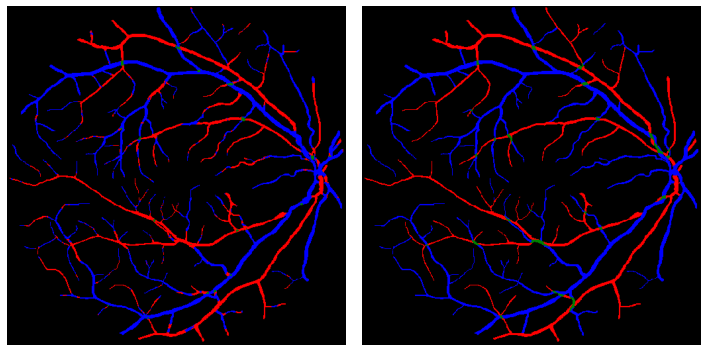

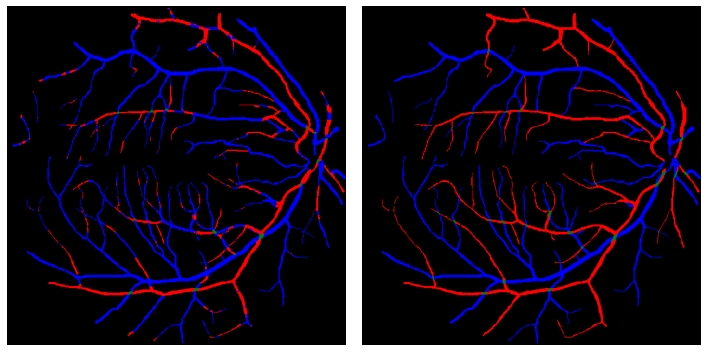

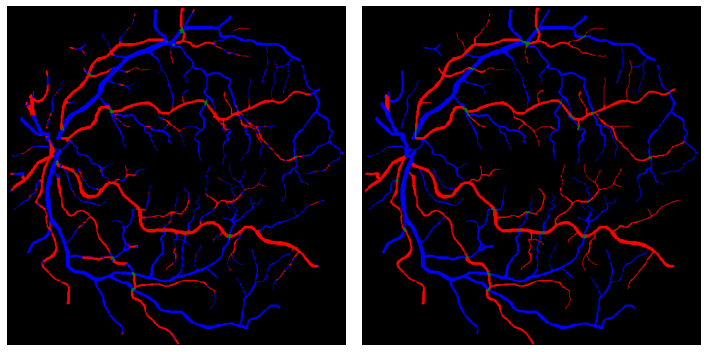

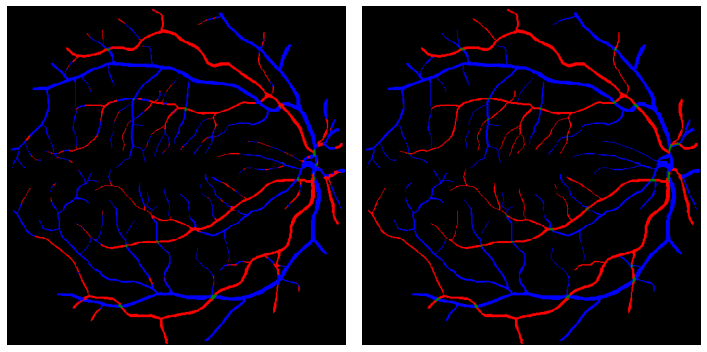

In [17]:
with torch.no_grad():
    vl_d_unc, vl_d_arts, vl_d_veins, vl_f1, vl_mcc, tr_loss = run_one_epoch(val_loader, model, criterion, 
                                                             optimizer=None, scheduler=None,
                                                             grad_acc_steps=0, assess=True, 
                                                             save_plot=True, cycle=0)

In [18]:
vl_f1

0.8337310563686511